In [1]:
from dotenv import load_dotenv
load_dotenv()
import os
fred_api_key = os.getenv("FRED_API_KEY")
import fredapi as fr
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import root_mean_squared_error,r2_score,mean_absolute_percentage_error


device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)


fred = fr.Fred(fred_api_key)



USDEURO = fred.get_series("DEXUSEU")
USDEURO.name = "USDEURO"

df = pd.concat([USDEURO],axis=1).dropna()
df = df.reset_index()
df['Date'] = df['index']
df['EUROUSD'] = 1 / df['USDEURO']
df.drop('index',axis=1,inplace=True)




cuda


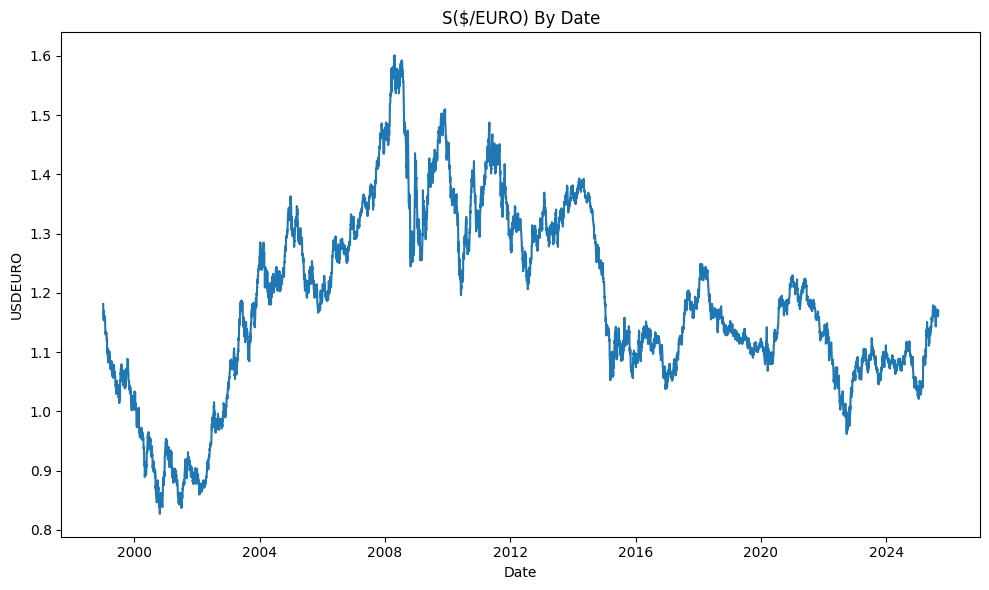

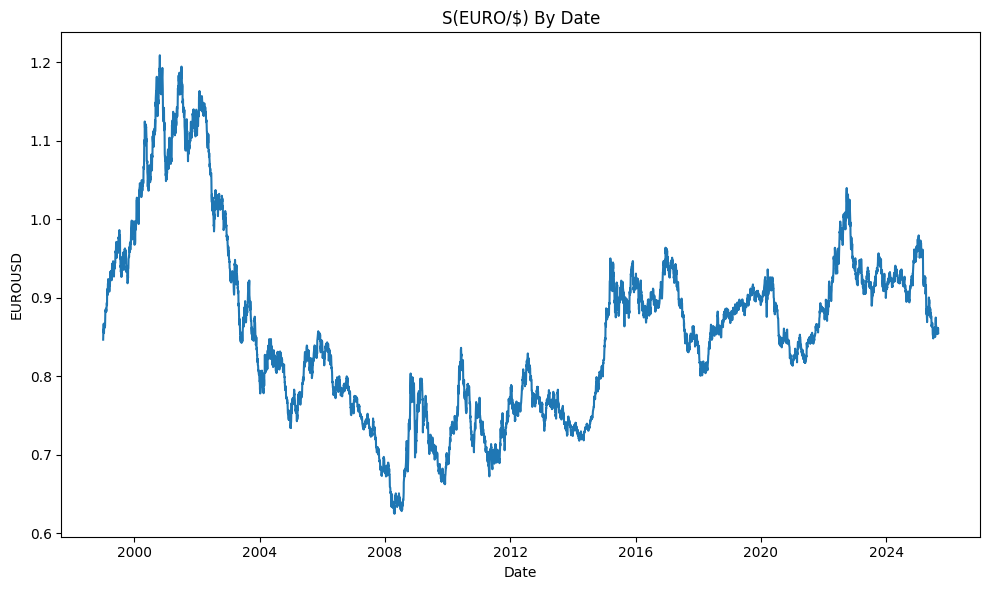

In [2]:
# S(EURO/USD)


plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y='USDEURO',data=df)
plt.title("S($/EURO) By Date")
plt.savefig("images/spotrate_S_usd_euro.png")
plt.tight_layout()
plt.show()


plt.figure(figsize=(10,6))
sns.lineplot(x='Date',y='EUROUSD',data=df)
plt.title("S(EURO/$) By Date")
plt.savefig("images/spotrate_eurousd.png")
plt.tight_layout()
plt.show()

In [3]:
df.drop('EUROUSD',inplace=True,axis=1)
df.drop_duplicates(inplace=True)
training = df.iloc[:,0:1].values
train_size = int(len(training) * .80)


train_data = training[:train_size]
test_data = training[train_size:]


scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)







def slider(data,seq_length):
    X,y = [],[]
    for i in range(len(data) - seq_length):
        Xi = data[i:(i+seq_length)]
        yi = data[(i+seq_length)]
        X.append(Xi)
        y.append(yi)
        
    return np.array(X),np.array(y)

seq_length = 1

X_train,y_train = slider(train_scaled,seq_length)
X_test,y_test = slider(test_scaled,seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()


class GRU(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRU, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, X):
        h0 = torch.zeros(1, X.size(0), self.hidden_size)
        out, _ = self.gru(X, h0)
        out = self.fc(out[:,-1,:])
        return out



input_size = 1
hidden_size = 256
num_layers = 1
output_size = 1

model = GRU(input_size, hidden_size, num_layers, output_size)
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
loss_fn = nn.MSELoss()
epochs = 500

for epoch in range(epochs):
    y_pred = model(X_train)
    loss = loss_fn(y_pred.float(),y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % 1 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred,y_train))
        y_pred_test =  model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred_test,y_test))
        print(f'Epoch: {epoch}; train_RMSE: {train_rmse:.4}; Test RMSE: {test_rmse:.4}')





/tmp/ipykernel_40335/1059809459.py:82: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  train_rmse = np.sqrt(loss_fn(y_pred,y_train))
/tmp/ipykernel_40335/1059809459.py:84: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  test_rmse = np.sqrt(loss_fn(y_pred_test,y_test))


Epoch: 0; train_RMSE: 0.5055; Test RMSE: 0.3469
Epoch: 1; train_RMSE: 0.4928; Test RMSE: 0.3343
Epoch: 2; train_RMSE: 0.4802; Test RMSE: 0.3217
Epoch: 3; train_RMSE: 0.4676; Test RMSE: 0.3091
Epoch: 4; train_RMSE: 0.4552; Test RMSE: 0.2966
Epoch: 5; train_RMSE: 0.4427; Test RMSE: 0.2842
Epoch: 6; train_RMSE: 0.4304; Test RMSE: 0.2718
Epoch: 7; train_RMSE: 0.418; Test RMSE: 0.2593
Epoch: 8; train_RMSE: 0.4056; Test RMSE: 0.2468
Epoch: 9; train_RMSE: 0.3933; Test RMSE: 0.2343
Epoch: 10; train_RMSE: 0.3809; Test RMSE: 0.2218
Epoch: 11; train_RMSE: 0.3685; Test RMSE: 0.2092
Epoch: 12; train_RMSE: 0.3561; Test RMSE: 0.1965
Epoch: 13; train_RMSE: 0.3436; Test RMSE: 0.1838
Epoch: 14; train_RMSE: 0.3312; Test RMSE: 0.1711
Epoch: 15; train_RMSE: 0.3188; Test RMSE: 0.1584
Epoch: 16; train_RMSE: 0.3064; Test RMSE: 0.1458
Epoch: 17; train_RMSE: 0.2941; Test RMSE: 0.1333
Epoch: 18; train_RMSE: 0.2819; Test RMSE: 0.121
Epoch: 19; train_RMSE: 0.2699; Test RMSE: 0.1091
Epoch: 20; train_RMSE: 0.2581; T

In [6]:
with torch.no_grad():
    pred = model(X_test)
    pred_np = pred.cpu().numpy()
    y_test_np = y_test.cpu().numpy()
    pred_rescaled = scaler.inverse_transform(pred_np)
    actual_rescaled = scaler.inverse_transform(y_test_np)


rmse = root_mean_squared_error(actual_rescaled,pred_rescaled)
r2 = r2_score(actual_rescaled,pred_rescaled)
print(f'RMSE: {rmse}')
print(f'R2 Score: {r2*100:.2f}%')


test_dates = df.iloc[train_size + seq_length:]['Date'].reset_index(drop=True)

comparison_df = pd.DataFrame({
    "Date": test_dates,
    "Actual Spot Rate": actual_rescaled.flatten(),
    "Predicted Spot Rate": pred_rescaled.flatten()
})

print(comparison_df.head(20))
print(comparison_df.tail(20))

RMSE: 0.005303109530359507
R2 Score: 99.18%
         Date  Actual Spot Rate  Predicted Spot Rate
0  2020-04-24            1.0798             1.080576
1  2020-04-27            1.0829             1.078898
2  2020-04-28            1.0836             1.081957
3  2020-04-29            1.0853             1.082648
4  2020-04-30            1.0934             1.084326
5  2020-05-01            1.0998             1.092327
6  2020-05-04            1.0911             1.098654
7  2020-05-05            1.0844             1.090054
8  2020-05-06            1.0806             1.083438
9  2020-05-07            1.0815             1.079688
10 2020-05-08            1.0854             1.080576
11 2020-05-11            1.0818             1.084425
12 2020-05-12            1.0864             1.080872
13 2020-05-13            1.0837             1.085412
14 2020-05-14            1.0800             1.082747
15 2020-05-15            1.0816             1.079096
16 2020-05-18            1.0904             1.080674
17

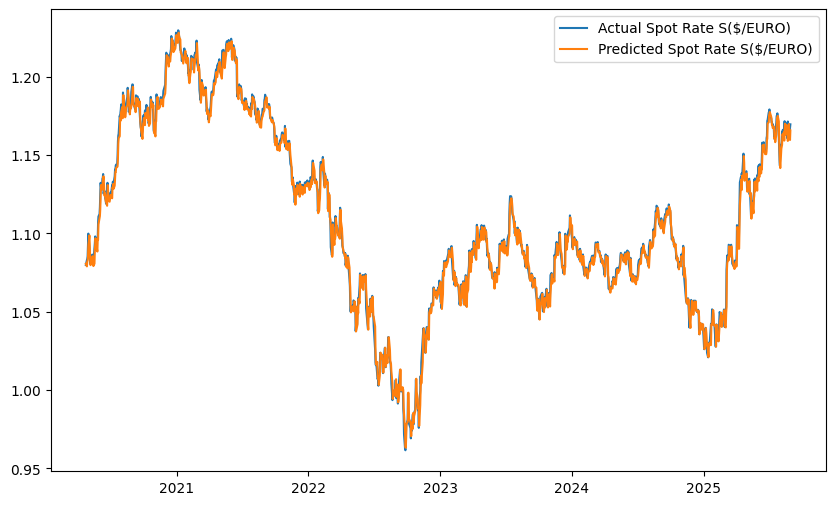

In [7]:
plt.figure(figsize=(10,6))
plt.plot(comparison_df['Date'],comparison_df["Actual Spot Rate"],label="Actual Spot Rate S($/EURO)")
plt.plot(comparison_df['Date'],comparison_df['Predicted Spot Rate'],label="Predicted Spot Rate S($/EURO)")
plt.legend()
plt.savefig("images/predicted_vs_actual_SpotRate.png")
plt.show()